<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/for-example-and-testing/superpixels_visualization_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualization of the superpixel images, graphs and edge connections

### Superpixels from
https://github.com/bknyaz/graph_attention_pool

https://github.com/graphdeeplearning/benchmarking-gnns/blob/master/visualization/superpixels_visualization_mnist.ipynb

In [2]:
!pip install torch==2.0.0+cpu torchvision==0.15.1+cpu torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cpu > /dev/null
!pip install  dgl==1.1.0 -f https://data.dgl.ai/wheels/repo.html > /dev/null

In [3]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['DGLBACKEND'] = "pytorch"

In [6]:
import dgl

In [5]:
import random
from torchvision import transforms, datasets

import os
import pickle
from scipy.spatial.distance import cdist
from scipy import ndimage
import numpy as np


import torch
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

In [7]:

os.chdir('../') # go to root folder of the project
print(os.getcwd())

/


### Functions definition for graph construction

In [8]:
def sigma(dists, kth=8):
    # Get k-nearest neighbors for each node
    knns = np.partition(dists, kth, axis=-1)[:, kth::-1]

    # Compute sigma and reshape
    sigma = knns.sum(axis=1).reshape((knns.shape[0], 1))/kth
    return sigma + 1e-8 # adding epsilon to avoid zero value of sigma

def compute_adjacency_matrix_images(coord, feat, use_feat=False, kth=8):
    coord = coord.reshape(-1, 2)
    # Compute coordinate distance
    c_dist = cdist(coord, coord)

    if use_feat:
        # Compute feature distance
        f_dist = cdist(feat, feat)
        # Compute adjacency
        A = np.exp(- (c_dist/sigma(c_dist))**2 - (f_dist/sigma(f_dist))**2 )
    else:
        A = np.exp(- (c_dist/sigma(c_dist))**2)

    # Convert to symmetric matrix
    A = 0.5 * (A + A.T)
    #A = 0.5 * A * A.T
    A[np.diag_indices_from(A)] = 0
    return A

def compute_edges_list(A, kth=8+1):
    # Get k-similar neighbor indices for each node
    if 1==1:
        num_nodes = A.shape[0]
        new_kth = num_nodes - kth
        knns = np.argpartition(A, new_kth-1, axis=-1)[:, new_kth:-1]
        knns_d = np.partition(A, new_kth-1, axis=-1)[:, new_kth:-1]
    else:
        knns = np.argpartition(A, kth, axis=-1)[:, kth::-1]
        knns_d = np.partition(A, kth, axis=-1)[:, kth::-1]
    return knns, knns_d

### MNISTSuperPix class for reading superpixels file and constructing graph

In [9]:
class MNISTSuperPix(torch.utils.data.Dataset):
    def __init__(self,
                 data_dir,
                 split,
                 use_mean_px=True,
                 use_coord=True,
                 use_feat_for_graph_construct=False,):

        self.split = split
        self.is_test = split.lower() in ['test', 'val']
        with open(os.path.join(data_dir, 'mnist_75sp_%s.pkl' % split), 'rb') as f:
            self.labels, self.sp_data = pickle.load(f)

        self.use_mean_px = use_mean_px
        self.use_feat_for_graph = use_feat_for_graph_construct
        self.use_coord = use_coord
        self.n_samples = len(self.labels)
        self.img_size = 28

    def precompute_graph_images(self):
        print('precompute all data for the %s set...' % self.split.upper())
        self.Adj_matrices, self.node_features, self.edges_lists = [], [], []
        for index, sample in enumerate(self.sp_data):
            mean_px, coord = sample[:2]
            coord = coord / self.img_size
            A = compute_adjacency_matrix_images(coord, mean_px, use_feat=self.use_feat_for_graph)
            edges_list, _ = compute_edges_list(A)
            N_nodes = A.shape[0]

            x = None
            if self.use_mean_px:
                x = mean_px.reshape(N_nodes, -1)
            if self.use_coord:
                coord = coord.reshape(N_nodes, 2)
                if self.use_mean_px:
                    x = np.concatenate((x, coord), axis=1)
                else:
                    x = coord
            if x is None:
                x = np.ones(N_nodes, 1)  # dummy features

            self.node_features.append(x)
            self.Adj_matrices.append(A)
            self.edges_lists.append(edges_list)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        g = dgl.DGLGraph()
        g.add_nodes(self.node_features[index].shape[0])
        g.ndata['feat'] = torch.Tensor(self.node_features[index])
        for src, dsts in enumerate(self.edges_lists[index]):
            g.add_edges(src, dsts[dsts!=src])

        return g, self.labels[index]

In [10]:
if not os.path.isfile('superpixels.zip'):
    print('downloading..')
    !curl https://www.dropbox.com/s/y2qwa77a0fxem47/superpixels.zip?dl=1 -o superpixels.zip -J -L -k
    !unzip superpixels.zip -d ../
    # !tar -xvf superpixels.zip -C ../
else:
    print('File already downloaded')

File already downloaded


### Taking only coordinates for knn graph construction
This is done by setting `use_feat_for_graph_construct = False`.   
If you want to also consider the mean feature intensity of superpixels for the constructing the knn graphs, set `use_feat_for_graph_construct = True`

In [11]:
# Taking the test dataset only for sample visualization
use_feat_for_graph_construct = False
tt = time.time()
data_no_feat_knn = MNISTSuperPix("../superpixels",
                             #split='test',
                             split='train',
                             use_feat_for_graph_construct=use_feat_for_graph_construct)

data_no_feat_knn.precompute_graph_images()
print("Time taken: {:.4f}s".format(time.time()-tt))

precompute all data for the TRAIN set...
Time taken: 35.8950s


### Taking coordinates and features for knn graph construction

In [12]:
use_feat_for_graph_construct = True
tt = time.time()
data_with_feat_knn = MNISTSuperPix("../superpixels",
                             #split='test',
                             split='train',
                             use_feat_for_graph_construct=use_feat_for_graph_construct)

data_with_feat_knn.precompute_graph_images()
print("Time taken: {:.4f}s".format(time.time()-tt))

precompute all data for the TRAIN set...
Time taken: 46.2843s


### Prepare MNIST Images

In [14]:
#dataset = datasets.MNIST(root='PATH', train=False, download=True, transform=transforms.ToTensor())
dataset = datasets.MNIST(root='PATH', train=True, download=True, transform=transforms.ToTensor())

In [15]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: PATH
    Split: Train
    StandardTransform
Transform: ToTensor()

In [22]:
!pip install numpy==1.24.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 55.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.1 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.1 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.24.1 which is incompatible.
blosc2 3.3.1 requires numpy>=1.26, but you have numpy 1.24.1 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.24.1 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 

In [21]:
train_loader_pytorch = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
# Create a figure to display the images
plt.figure(figsize=(15, 3))

# Print the first few images in a row
for i, (image, label) in enumerate(train_loader_pytorch):
    if i < 5:  # Print the first 5 samples
        plt.subplot(1, 5, i + 1)
        plt.imshow(image[0].squeeze(), cmap='gray')
        plt.title(f"Label: {label.item()}")
        plt.axis('off')
    else:
        break  # Exit the loop after printing 5 samples

plt.tight_layout()
plt.show()

RuntimeError: Numpy is not available

<Figure size 1500x300 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
# Define the transformation to convert images to PyTorch tensors
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset with the specified transformation
mnist_pytorch = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader to load the dataset in batches
train_loader_pytorch = torch.utils.data.DataLoader(mnist_pytorch, batch_size=1, shuffle=False)

# Create a figure to display the images
plt.figure(figsize=(15, 3))

# Print the first few images in a row
for i, (image, label) in enumerate(train_loader_pytorch):
    if i < 5:  # Print the first 5 samples
        plt.subplot(1, 5, i + 1)
        plt.imshow(image[0].squeeze(), cmap='gray')
        plt.title(f"Label: {label.item()}")
        plt.axis('off')
    else:
        break  # Exit the loop after printing 5 samples

plt.tight_layout()
plt.show()

RuntimeError: Numpy is not available

<Figure size 1500x300 with 0 Axes>

In [26]:
x, _ = dataset[777] # x is now a torch.Tensor
#plt.imshow(x.numpy()[0], cmap='gray')

RuntimeError: Numpy is not available

### Drawing a dgl graph using networkx

In [44]:
sample = np.random.choice(len(data_no_feat_knn))
sample

43250

In [53]:
data_no_feat_knn[1][1]

/usr/local/lib/python3.11/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


RuntimeError: Could not infer dtype of numpy.int64

In [51]:
g_sample = data_no_feat_knn[sample][0]
print("Label: ", data_no_feat_knn[sample][1])
nx.draw(g_sample.to_networkx(), with_labels=True)
plt.show()

RuntimeError: Could not infer dtype of numpy.int64

### Superpixels plot function definition

In [35]:
from scipy.spatial.distance import pdist, squareform
from pylab import rcParams

def plot_superpixels_graph(plt, sp_data, adj_matrix, label, feat_coord, with_edges):
    Y = squareform(pdist(sp_data[1], 'euclidean'))
    x_coord = sp_data[1] #np.flip(dataset.train.sp_data[_][1], 1)
    intensities = sp_data[0].reshape(-1)

    G = nx.from_numpy_matrix(Y)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    rotated_pos = {node: (y,-x) for (node, (x,y)) in pos.items()} # rotate the coords by 90 degree

    edge_list = []
    for src, dsts in enumerate(compute_edges_list(adj_matrix)[0]):
        for dst in dsts:
            edge_list.append((src, dst))

    nx.draw_networkx_nodes(G, rotated_pos, node_color=intensities, cmap=matplotlib.cm.Reds, node_size=60) #len(intensities))
    if with_edges:
        nx.draw_networkx_edges(G, rotated_pos, edge_list, alpha=0.3)
    title = "Label: " + str(label)
    if feat_coord:
        title += " | Using feat and coord for knn"
    else:
        title += " | Using only coord for knn"
    if not with_edges:
        title = "Label: " + str(label) + " | Only superpixel nodes"

    plt.title.set_text(title)

def show_image(plt, idx, alpha):
    x, label = dataset[idx] # x is now a torch.Tensor
    img = x.numpy()[0]

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title.set_text("Label: " + str(label) + " | Original Image")

### Plotting sample superpixels, and graphs

RuntimeError: Numpy is not available

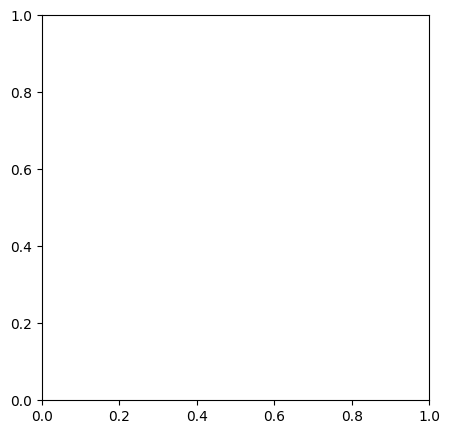

In [48]:
num_samples_plot = 3
for f_idx, idx in enumerate(np.random.choice(int(len(data_no_feat_knn)/2), num_samples_plot, replace=False)):
    f = plt.figure(f_idx, figsize=(23, 5))
    plt1 = f.add_subplot(141)
    show_image(plt1, idx, alpha=0.5)

    plt2 = f.add_subplot(142)
    plot_superpixels_graph(plt2, data_no_feat_knn.sp_data[idx],
                           data_no_feat_knn.Adj_matrices[idx],
                           data_no_feat_knn[idx][1],
                           data_no_feat_knn.use_feat_for_graph,
                           with_edges=False)

    plt3 = f.add_subplot(143)
    plot_superpixels_graph(plt3, data_no_feat_knn.sp_data[idx],
                           data_no_feat_knn.Adj_matrices[idx],
                           data_no_feat_knn[idx][1],
                           data_no_feat_knn.use_feat_for_graph,
                           with_edges=True)

    plt4 = f.add_subplot(144)
    plot_superpixels_graph(plt4, data_with_feat_knn.sp_data[idx],
                           data_with_feat_knn.Adj_matrices[idx],
                           data_with_feat_knn[idx][1],
                           data_with_feat_knn.use_feat_for_graph,
                           with_edges=True)

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    f.savefig('visualization/mnist_superpix_'+str(idx)+'.jpg')
    plt.show()

### Get k-nearest neighbor distances for first 10 (denoted by [:10]) nodes for first graph (denoted by [0])

In [49]:
print(compute_edges_list(data_no_feat_knn.Adj_matrices[0])[1][:10])

[[0.09706189 0.22495444 0.28615136 0.33317745 0.34129913 0.51117053
  0.52772944 0.53148042]
 [0.11622447 0.11643382 0.14337682 0.31264955 0.38031212 0.41040945
  0.55852654 0.57527578]
 [0.07879756 0.13634269 0.16299043 0.17115684 0.32326526 0.33184574
  0.59094695 0.635376  ]
 [0.14422585 0.18071243 0.29624541 0.3099813  0.37735079 0.43810587
  0.49465879 0.55808969]
 [0.09554143 0.10081679 0.20927748 0.24541025 0.34380428 0.37591439
  0.50469304 0.6753061 ]
 [0.12112973 0.12720588 0.32896017 0.54677912 0.53022076 0.50550776
  0.30125468 0.55290513]
 [0.12017464 0.260641   0.26890236 0.2786191  0.34942164 0.38031212
  0.47347347 0.60689099]
 [0.10011198 0.32140606 0.32597683 0.34942164 0.40084915 0.42066611
  0.50868236 0.51652385]
 [0.16759285 0.25717448 0.260641   0.26297668 0.26555027 0.43015687
  0.43259517 0.55852654]
 [0.10097329 0.13137306 0.27912126 0.34076311 0.34791732 0.47156964
  0.52256289 0.54158443]]


In [50]:
print(compute_edges_list(data_with_feat_knn.Adj_matrices[0])[1][:10])

[[8.51586803e-02 9.70618866e-02 2.86151356e-01 3.33177454e-01
  3.41299129e-01 5.11170529e-01 5.27729445e-01 5.31480419e-01]
 [1.13101417e-04 1.84309803e-04 1.56313347e-03 7.31807712e-03
  7.66930403e-03 1.74267837e-02 8.29038701e-02 1.53355864e-01]
 [7.58031764e-02 7.87975630e-02 1.62990428e-01 1.71156842e-01
  3.23265264e-01 3.31845741e-01 5.90946952e-01 6.35376005e-01]
 [2.93434270e-03 3.88460164e-03 4.13922762e-03 7.10047442e-03
  7.11912787e-03 9.15331246e-03 5.94741403e-02 8.84572921e-02]
 [1.29912507e-02 2.69469917e-02 3.57949843e-02 1.00816789e-01
  2.45410247e-01 3.43804280e-01 5.04693038e-01 6.75306102e-01]
 [6.42733887e-02 7.67858361e-02 7.87975630e-02 1.27205879e-01
  2.86151356e-01 3.01254684e-01 3.28960174e-01 5.30220763e-01]
 [2.46982936e-20 1.34098933e-18 4.56881538e-13 8.89060839e-09
  1.41522616e-06 1.52867868e-06 1.29695687e-03 5.04141459e-03]
 [1.16330661e-04 1.26978140e-04 1.34290780e-04 2.09995735e-04
  2.54032490e-04 2.54032541e-04 2.17967996e-03 1.74267837e-02]
